# THE WAR AGAINST HEART ARRHYTHMIA

In [2]:
!pip install arch

    100% |████████████████████████████████| 706kB 8.9MB/s eta 0:00:01
    100% |████████████████████████████████| 10.0MB 93kB/s eta 0:00:01   3% |█▏                              | 368kB 36.6MB/s eta 0:00:01████▍                          | 1.7MB 8.8MB/s eta 0:00:01
  Found existing installation: pandas 0.19.2
    Uninstalling pandas-0.19.2:
      Successfully uninstalled pandas-0.19.2


In [2]:
import numpy as np
import math
import pywt
import pandas as pd
import scipy.signal
import wfdb
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from collections import deque
from arch.unitroot import VarianceRatio
import statsmodels.graphics.tsaplots as st
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Loading and viewing the data

In [2]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\ahmad\\Desktop\\UC3M\\Thesis\\Python_Workspace\\Code_thesis'

In [3]:
annotations = pd.read_csv('./data_thesis/mitbih_database/102annotations.txt',delimiter = '\t')
annotations

,Time Sample # Type Sub Chan Num,Aux
0,0:00.189 68 + 0 0 0,(P
1,0:00.378 136 / 0 0 0,NaN
2,0:01.139 410 / 0 0 0,NaN
3,0:01.936 697 / 0 0 0,NaN
4,0:02.747 989 / 0 0 0,NaN
5,0:03.625 1305 / 0 0 0,NaN
6,0:04.483 1614 / 0 0 0,NaN
7,0:05.308 1911 / 0 0 0,NaN
8,0:06.114 2201 / 0 0 0,NaN
9,0:06.914 2489 / 0 0 0,NaN


In [4]:
MIT_data = pd.read_csv("./data_thesis/mitbih_database/102.csv")
MIT_data = MIT_data.iloc[:,1:3].astype("float")

In [5]:
MIT_data_col1 = MIT_data.iloc[:,0]
MIT_data_first = MIT_data_col1.astype("float")
MIT_data_first.shape

(650000,)

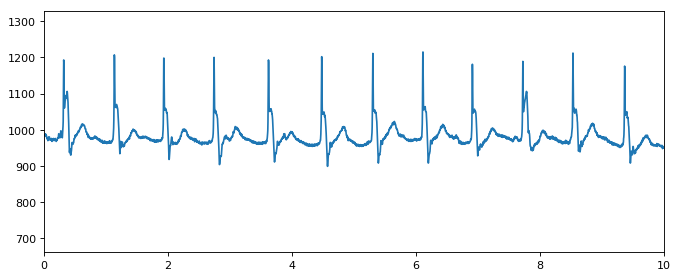

In [6]:
fs = 360
time = np.arange(MIT_data_first.size)/fs
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_data_first)

# Step 1: Subtract the mean

In [7]:
mean1 = np.mean(MIT_data.iloc[:,0])
mean2 = np.mean(MIT_data.iloc[:,1])

print(mean1)
print(mean2)

974.8292461538462
1026.5165523076923


In [8]:
MIT_data.iloc[:,0] = MIT_data.iloc[:,0] - mean1

In [9]:
MIT_data.iloc[:,1] = MIT_data.iloc[:,1] - mean2

# Step 2: Five order moving average filtering

In [10]:
def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l)
 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
 
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
 
    return result

In [11]:
MIT_data.iloc[:,0] = moving_average(MIT_data.iloc[:,0],5)

In [12]:
MIT_data.iloc[:,1] = moving_average(MIT_data.iloc[:,1],5)

In [13]:
MIT_data = MIT_data.astype("float")

(0, 10)

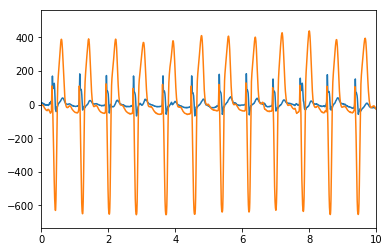

In [14]:
plt.plot(time,MIT_data)
plt.xlim(0,10)

# Step 3: High Pass Filtering with f = 1 Hz (Drift Suppression)

In [15]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [16]:
fs = 360
cutoff = 1
order = 5
MIT_conditioned_signal = butter_highpass_filter(MIT_data.iloc[:,0], cutoff, fs, order)

In [17]:
MIT_conditioned_signal

array([-4.23202213, -4.31511506, -4.39902854, ...,  3.29638229,
        1.65692434,  7.8239824 ])

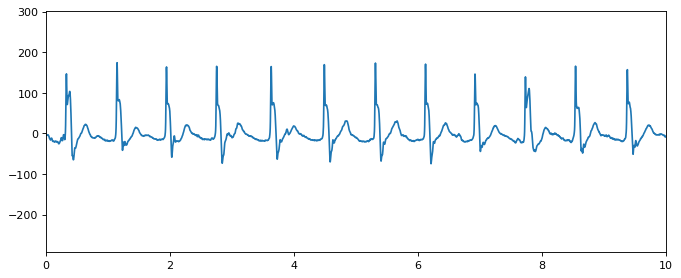

In [18]:
#time = np.arange(MIT_conditioned_signal.size)
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_conditioned_signal)

# Step 4: low-pass Butterworth filtering with fc = 30 Hz

In [19]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [20]:
order = 5
fs = 30
cutoff = 1

MIT_signal = butter_lowpass_filter(MIT_conditioned_signal, cutoff, fs, order)

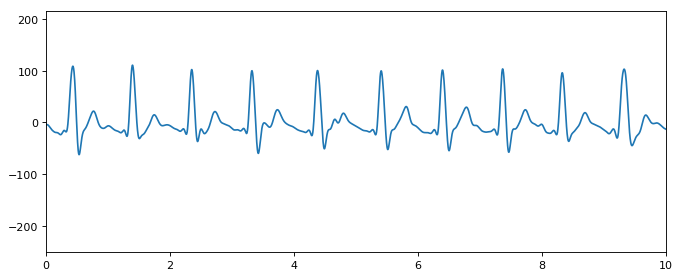

In [21]:
fs=30
time = np.arange(MIT_signal.size)/fs
time = time/10
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_signal)

# Time parameter

In [22]:
t_cst = len(MIT_signal)/time[-1]
t_cst  ##number of signal points in 1 second

300.00046153917157

## Parameter 1: TCI

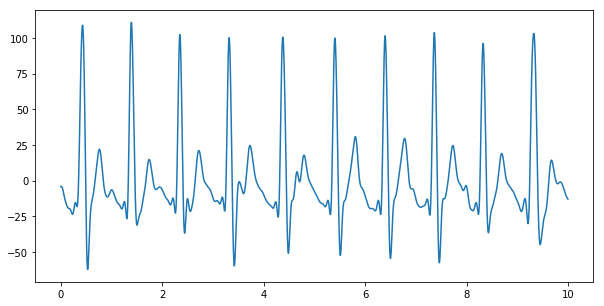

In [26]:
MIT_signal.size
time.size
time[300]
time[600]
plt.figure(figsize=(10,5))
plt.plot(time[0:3000],MIT_signal[0:3000])

In [30]:
def binary_td(signal,m,n):
    threshold = np.arange(n-m).astype("float")
    k = m
    s = m
    z = 0
    binary_list = []
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(MIT_signal[int(np.ceil(m*300)):int(np.ceil((m+1)*300))])
        i+=1
        m+=1
    for l in threshold:
        p = 0
        for j in signal[int(np.ceil(k*300)):int(np.ceil((k+1)*300))]:
            if j < l :
                binary_list.append(0)
            else: 
                binary_list.append(1)
        k+=1
    plt.figure(figsize=(10,5))
    plt.plot(time[s*300:n*300],binary_list)
    return np.array(binary_list),threshold

array([0, 0, 0, ..., 0, 0, 0])

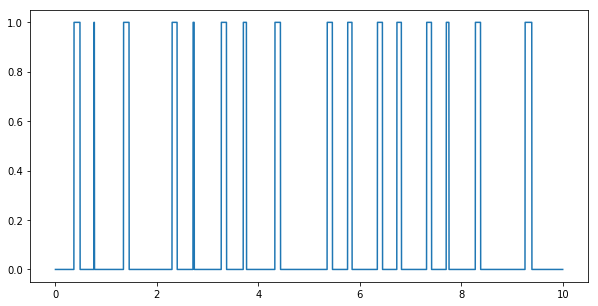

In [31]:
binlist,thd = binary_td(MIT_signal,0,10)
binlist[300:2700]

In [32]:
def TCI(binlist,thd,m,n):
    pulses = [0]*(n-m+2)
    q = 0
    p = 300
    ## pulse calculation:
    k=0
    for i in range(len(thd)):
        bin2 = binlist[q:p]
        for i in range(len(bin2)-1):
            if bin2[i]!=bin2[i+1]:
                pulses[k]+=1
        pulses[k] = pulses[k]/2
        k+=1
        q+=300
        p+=300
    q = 0
    p=900
    k=0
    t1_idx = 0
    t2_idx = 0
    t3_idx = 0
    t4_idx = 0
    TCI=[]
    for l in range(len(thd)-2):
        countidx1 = 0
        countidx2 = 0
        countidx3 = 0
        countidx4 = 0
        bin2 = binlist[q:p]
        
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx1+=1
                if countidx1/2 == pulses[k]:
                    t1_idx = f+q
                    break
        h1 = q+300
        bin2=binlist[h1:p]
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t2_idx = h1+f+1
                break
                    
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx3 +=1
                if countidx3/2 == pulses[k+1]:
                    t3_idx = f+h1
                    break
        h2 = q+600            
        bin2 =binlist[h2:p]             
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t4_idx = f+1+h2
                break
        t1 = (h1-t1_idx)/300
        t2 = (t2_idx-h1)/300
        t3 = (h2 - t3_idx)/300
        t4 = (t4_idx-h2)/300
        
        form1 = (pulses[k+1]-1)+(t2/(t1+t2))+(t3/(t3+t4))
        form2=1000/form1
        TCI.append(form2)
        q+=300
        p+=300
        k+=1
    return np.array(TCI)

array([804.87137384, 540.58858384, 519.96025149, 837.8015606 ,
       589.08778502, 486.52131887, 475.13366287, 808.4102124 ])

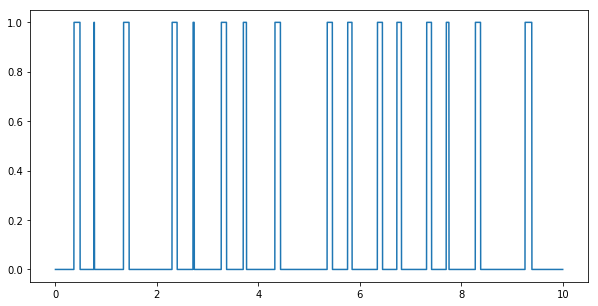

In [33]:
binlist,thd = binary_td(MIT_signal,0,10)
TCI(binlist,thd,1,9)

## Parameter 2: ACF

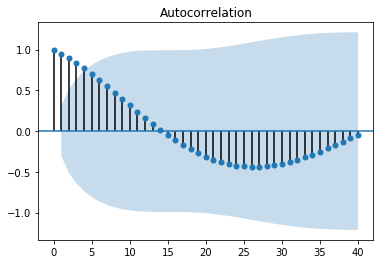

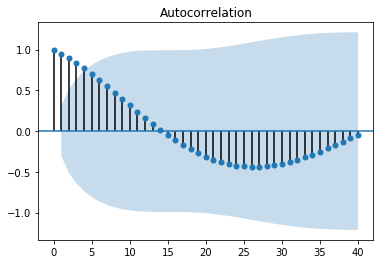

In [34]:
ser = acf(MIT_signal[0:2400],13)
st.plot_acf(ser)

In [35]:
ser

array([ 1.        ,  0.99700306,  0.98723048,  0.97080113,  0.94791642,
        0.91885653,  0.88397515,  0.84369301,  0.79849015,  0.7488974 ,
        0.69548698,  0.63886277,  0.57965021,  0.51848618,  0.45600913,
        0.39284955,  0.32962095,  0.26691162,  0.20527725,  0.14523437,
        0.08725493,  0.03176177, -0.02087475, -0.07033913, -0.11637214,
       -0.15877123, -0.19739006, -0.23213725, -0.26297439, -0.28991334,
       -0.313013  , -0.33237564, -0.34814273, -0.36049052, -0.36962536,
       -0.37577878, -0.3792026 , -0.38016387, -0.37893994, -0.37581356,
       -0.37106821])

In [36]:
vr = VarianceRatio(ser,13)
vr.overlap=False
print(vr)

     Variance-Ratio Test Results     
Test Statistic                  8.738
P-value                         0.000
Lags                               13
-------------------------------------

Computed with non-overlapping blocks


D:\Anaconda3\lib\site-packages\arch\unitroot\unitroot.py:1485: InvalidLengthWarning: 
The length of y is not an exact multiple of 13, and so the final
1 observations have been dropped.

  InvalidLengthWarning)


## Parameter 3: VF Filter

In [37]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [38]:
get_points(MIT_signal,300)

49.0

In [39]:
leakage(MIT_signal,int(get_points(MIT_signal,300)),200,500)

0.6344872215219527

## Parameter 4: Spectral Algorithm

In [40]:
Ham = MIT_signal[0:2400]*np.hamming(2400)

(-120, 120)

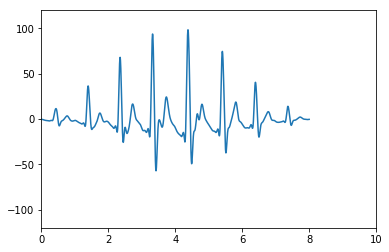

In [41]:
plt.plot(time[0:2400],Ham)
plt.xlim(0,10)
plt.ylim(-120,120)

In [42]:
fourier = scipy.fft(Ham)

In [43]:
fourier

array([-5.50897688+0.j        , -5.68080042+0.04209101j,
       -6.30559754+0.23384608j, ..., -9.66289421-3.78073608j,
       -6.30559754-0.23384608j, -5.68080042-0.04209101j])

D:\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 10)

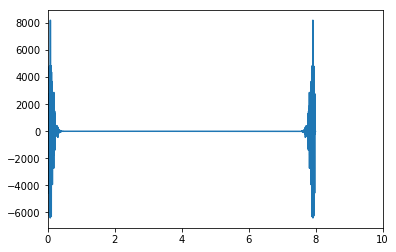

In [44]:
plt.plot(time[0:2400],fourier)
plt.xlim(0,10)

In [45]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [46]:
fourier_2 = fourier_abs(fourier)

In [47]:
fourier_2

array([ 5.50897688+0.j,  5.72289144+0.j,  6.53944362+0.j, ...,
       13.44363029+0.j,  6.53944362+0.j,  5.72289144+0.j])

(0, 10)

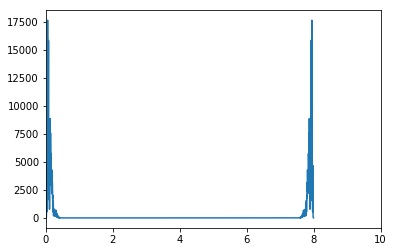

In [48]:
plt.plot(time[0:2400],fourier_2)
plt.xlim(0,10)

In [49]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

In [50]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m))
print(m)

5
(8860.244304804397+0j)


In [51]:
time_max_amp = f.index(m)/300 ## in seconds
God_of_War = 1/time_max_amp
God_of_War

60.0

In [52]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [53]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

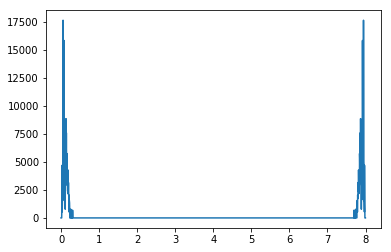

In [54]:
plt.plot(time[0:2400],fourier_final)

In [55]:
def moment_calc(fourier,omega,jmax):
    j=0
    s=0
    fft = fourier[0:int(np.amin([20*omega,100]))]
    while j <= jmax:
        freq = 300/j   ##fix time
        m = 1/omega
        s = s + (m*freq)
        j+=1

In [56]:
# moment_calc(fourier_final,God_of_War,f.index(m))

## Parameter 5: Complexity Measure Algorithm

In [57]:
nurgle = MIT_signal[0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

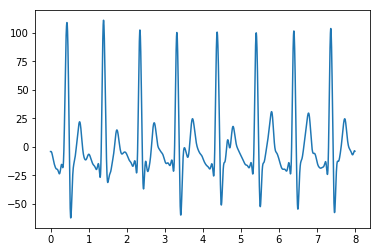

In [280]:
plt.plot(time[0:2400],nurgle)

In [281]:
def Td(Vp,Vn,nurgle):
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>nc:
        T = 0.2*Vn
    return T

In [282]:
Threshold = Td(Vp,Vn,nurgle)
Threshold

0

In [283]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [284]:
binary = binary_comp(Threshold,nurgle)
binary

array([0, 0, 0, ..., 0, 0, 0])

In [285]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary):
    cn = 1
    S = [binary[0]]
    Q = [binary[1]]
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C=substrings(con)
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) == len(binary)-1:
                cn+=1
                break
            Q = [binary[len(S)]]
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+[binary[len(S)+m]]
                m+=1
            else:
                break
    return cn

In [286]:
cn=complexity(binary[0:200])
cn

3

In [287]:
#cn = complexity(binary[0:200])
#cn
S= ['A','B','C','D','E']
Q= ['F']

sq = S+Q
combi = []
for i in range(len(sq)):
    combi.append(combinations(sq,i+1))
combi

In [288]:
bn = len(binary)/(math.log2(len(binary)))

In [289]:
complexity_measure = cn/bn
complexity_measure

0.014036023363119852

## Parameter 6: Standard Exponential Algorithm

In [58]:
def exp_algthm(t,signal,Tau):
    M = np.amax(signal)
    tm = (np.where(MIT_signal==M))[0]/300
    exp_part = np.exp((-1*np.absolute(t-tm))/Tau)
    curve = M*exp_part
    
    plt.figure(figsize=(20,10))
    plt.plot(t,signal)
    plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
    plt.plot(t[idx],signal[idx],'ro')
    
    Time_length = len(signal)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

172.5

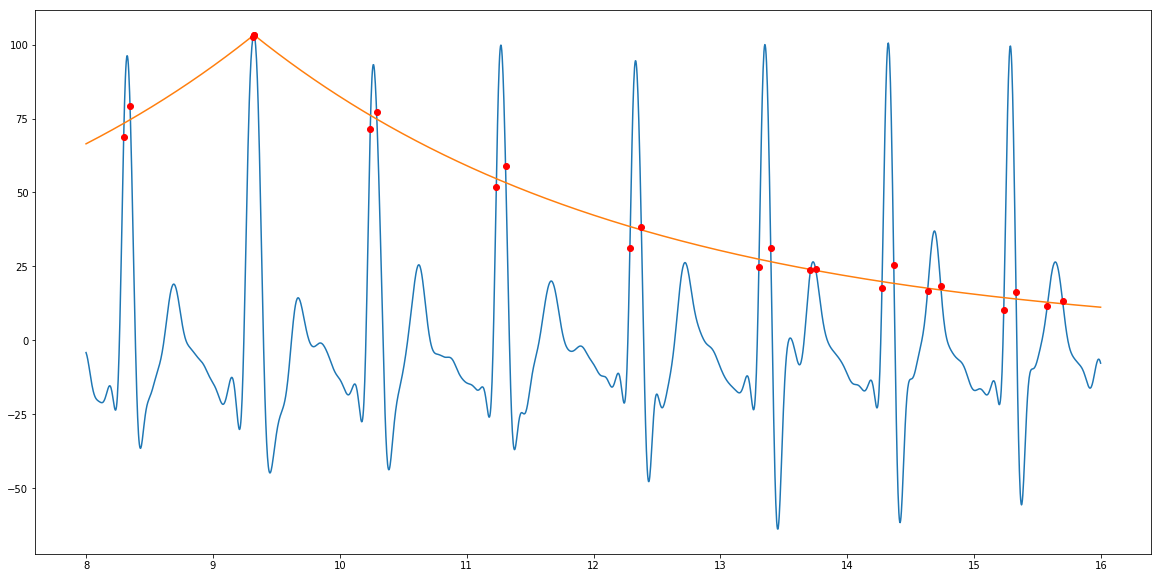

In [59]:
exp_algthm(time[2400:4800],MIT_signal[2400:4800],3)

## Parameter 7: Modified Exponential Algorithm

In [119]:
def MEA(t,signal,Tau):
    index_realM = real_maxes(t,signal,"(P")
    #index_realM = argrelextrema(signal,np.greater)
    index_realM2 = []
    for sp in index_realM:
        index_realM2.append(sp)
    tm = np.array(index_realM2)/300
    real_curve = [1.0]*len(t)
    k = 0
    aa=0
    for j in index_realM2:
        Mj = MIT_signal[j]
        tmj = tm[k]
        if k <= len(tm)-2:
            tmj1 =tm[k+1]
        else: 
            tmj1 = 2200
        exp_part = np.exp((-1*(t-tmj))/Tau)
        curve = Mj*exp_part
        idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
        idx = np.array(idx)
        if k < len(index_realM2)-1:
            tcj = idx[-1]/300
        else: 
            tcj = idx[3]/300
        l = 0
        kk = 0
        print(tmj,tcj,tmj1)
        for i in t: 
            if tmj <= i and i <=tcj:
                real_curve[l]=(curve[np.where(t == i)].item())
            elif tcj<= i <= tmj1:
                if signal[l] == curve[l]:
                    real_curve[l]=(signal[np.where(t == i)].item())
                    kk+=1
            l+=1
        if kk>0:
            aa+=1
        k+=1
    idx2 = np.argwhere(np.diff(np.sign(signal-real_curve))).flatten()
    plt.figure(figsize=(20,10))
    plt.plot(t,signal)
    plt.plot(t,real_curve)
    plt.plot(t[idx2],signal[idx2],'ro')
    
    numberofint = len(idx2)
    Time_length = len(signal)/300
    N = aa/Time_length
    return N*60
### How do I count the lifts? 
### Is this how we choose the relative maxes or do we consider them all? 
### time of crossing inequality? 
### Should I lift to the next max in the list or to the peak of the discovered intersection? 
### How Should I define the crossing time? 

In [120]:
MEA(time[0:2400],MIT_signal[0:2400],0.2)

0.43 7.833333333333333 1.3933333333333333
1.3933333333333333 7.833333333333333 2.35
2.35 7.833333333333333 3.32
3.32 7.833333333333333 3.73
3.73 7.833333333333333 4.376666666666667
4.376666666666667 7.833333333333333 5.403333333333333
5.403333333333333 7.833333333333333 5.806666666666667
5.806666666666667 7.833333333333333 6.3933333333333335
6.3933333333333335 7.83 6.776666666666666
6.776666666666666 7.83 7.363333333333333
7.363333333333333 7.78 7.73


IndexError: index 3 is out of bounds for axis 0 with size 2

In [96]:
(15/8)*60

112.5

## Parameter 8: Signal Comparison

In [63]:
def M0_creator(signal,time):
    M = argrelextrema(signal,np.greater)
    M0=np.zeros((len(M[0]),2))
    k=0
    for i in M[0]:
        M0[k,0] = time[i]
        M0[k,1] = signal[i]
        k+=1
    return M0

(-50, 200)

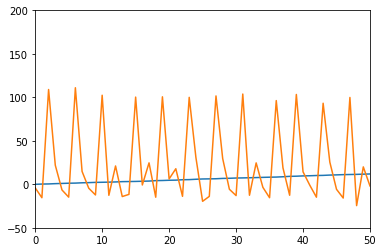

In [64]:
M0 = M0_creator(MIT_signal,time)
plt.plot(M0)
plt.xlim(0,50)
plt.ylim(-50,200)

In [121]:
def real_maxes(t,signal,ty):
    index_M = argrelextrema(signal,np.greater)
    index_realM = []
    for i in index_M[0]:
        if ty != "(VF" or ty != "(VFIB)":
            if signal[i] > 0.2*np.amax(signal):
                index_realM.append(i)
        else:
            if signal[i] > 0.1*np.amax(signal):
                index_realM.append(i)
    
    return index_realM
### Check if what you did here is correct! 

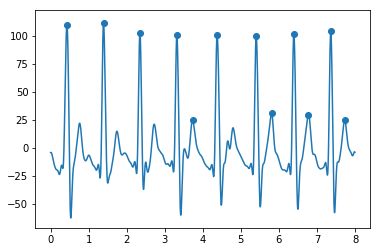

In [122]:
mm = real_maxes(time[0:2400],MIT_signal[0:2400],"(P")
plt.plot(time[0:2400],MIT_signal[0:2400])
plt.scatter(time[mm],MIT_signal[mm])

# Parameter 11: Tompkins Algorithm

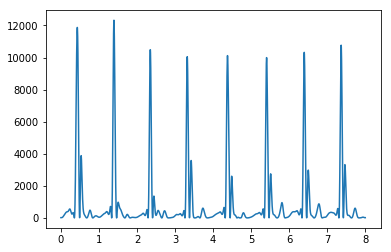

In [125]:
signal = np.power(MIT_signal[0:2400],2)
plt.plot(time[0:2400],signal)

In [126]:
def y(n,t,signal):
    T = t[-1]-t[0]
    y= (1/(8*T))*(-signal*(n*T-2*T)-2*signal*(n*T-T)+2*signal*(n*T+T)+signal*(n*T+2*T))
    return y

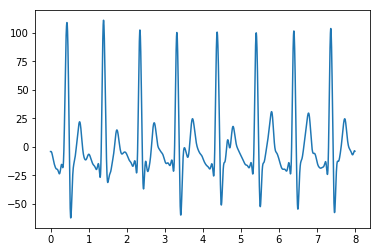

In [134]:
y = y(2400,time[0:2400],MIT_signal[0:2400])
plt.plot(time[0:2400],y)

In [139]:
y

array([-4.10418017, -4.07026194, -4.05013222, ..., -3.47668914,
       -3.60969611, -3.84355639])

In [140]:
MIT_signal[0:2400]

array([-4.10418017, -4.07026194, -4.05013222, ..., -3.47668914,
       -3.60969611, -3.84355639])

# Questions:

### Spectral Algorithm:

1. In the spectral Algorithm, Carlos and I talked about the jmax, I don't understand what they mean by "jmax being the index of the highest investigated frequency". I just wanted to see if you had maybe found something to explain it better?

### Amann paper Appendix B:

1. PQRST Detector
2. in Step 2, they say "amax has a corresponding temporal position tmax. Then, the largest possible temporal interval Il in Z around tmax is searched, so that all values aj in this interval are equal or smaller than amax and larger than 0.2 amax." What is meant by the largest possible temporal interval? 
3. What is the threshold for QRS detection?

### Signal Comparison Algorithm: 

1. Probability test for being the peak of a possible QRS complex? THey say refer to steps 1 and 2, but I'm not sure if finding hte right relative maxes is the same thing? 
2. If in hte above question it is the case that finding the relative maxes with the conditions provided in steps 1 and 2 is the probability test, then I'm stuck on the 2nd question of the previous cell. 

### LI Algorithm: 

1. I don't understand what the function f refers to in both equations, I don't understand how to use these formulas or do much of the alogrithm. I guess we should wait to discuss this in person unless you have a different reference for this alogirthm that maybe explains it differently? 

## Tompkins Algorithm:

1. I don't seem to understand how to apply the tompkin's algorithm. When I program the formula, all I get is the same signal, which if the formula itself is manipulated by hand, it just equals to the signal. 
2. I also don't know what they mean by a dual threshold technique and what a moving integration window is. 

### Data Issues:

I currently have the MITDB converted to csv and their annotations in text. I found them online on kaggle. However, I cannot seem to find or convert the CUDB to csv files, or their annotation files into text. I found a few converters shared online for these databases, that came in chunks of code, but they don't work well, I just get empty files. I also tried importing the .dat files. I cannot seem to be able to do so without the following error: 

In [3]:
signal_5520 = pd.read_csv('./data_thesis/MIT/102.dat',delimiter = '\t')
### the error is 'utf-8' codec can't decode byte 0xd8 in position 0: invalid continuation byte, I searched online but could not find much to solve the problem.

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd8 in position 0: invalid continuation byte

## Thank you for your time!